In [21]:
import os
import json
import numpy as np
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns

### GT data info and Attention Check

In [3]:
gt_df = pd.read_csv('../build/data/pilot_set-1.csv')
label_map = {"not sarcastic": 0, "sarcastic": 1}
gt_df['label'] = gt_df['original_label'].map(label_map)

In [4]:
gt_df

,conversation,original_label,original_data,label
0,"Turn 1:\nA: ""Have you noticed that Luna's been...",not sarcastic,I think our cat has separation anxiety.,0
1,"Turn 1:\nA: ""I've rewritten the social media p...",not sarcastic,Clapped out the post twice now.,0
2,"Turn 1:\nA: ""Hey, have you seen the email abou...",not sarcastic,Lucky I'm not going to that then…,0
3,Turn 1:\nA: I think we should invite Sarah and...,not sarcastic,nevermind i can't put them in,0
4,"Turn 1:\nA: ""Hey, can I take a look at the pos...",not sarcastic,Not to be a spelling nerd but please check you...,0
5,"Turn 1:\nA: Hi, I'm so glad you could make it ...",not sarcastic,Now is an amazing time to join the group. Musi...,0
6,Turn 1:\nA: I've been reading about the new st...,not sarcastic,If you don't have a PHD in immunology then you...,0
7,Turn 1:\nA: I'm just having trouble figuring o...,not sarcastic,sometimes i wish i could just do the most obvi...,0
8,Turn 1:\nA: I've been feeling like I've been s...,not sarcastic,New years resolution this year is to pick up s...,0
9,Turn 1:\nA: Have you been following the news a...,not sarcastic,It's like the whole world is becoming woke to ...,0


In [5]:
ATTENTION_CHECK_SIG = 'Please determine if the following statement is true or false.'
ATTENTION_CHECK_ANSWERS = {
    '1 + 1 = 2': True,
    'Texas is the capital of the United States.': False,
    'The sun rises from the north and sets at the west.': False,
}

## Load human data

In [7]:
human_result_path = 'raw_data.json'
human_data = json.load(open(human_result_path, 'r'))

In [25]:
# get individual subject data and convert to pandas dataframe
subject_dfs = {}
subject_attention_check = {}
subject_regular_questions = {}

for subject_id, data in human_data.items():
    if subject_id != 'surveys':
        print(f"Subject: {subject_id}")
        df = pd.DataFrame.from_dict(data)
        attention_check_results = []
        regular_question_results = []
        
        for i, row in df.iterrows():
            statement = row['statement']
            response = True if row['response'] == 'True' else False
            if row['question'] == ATTENTION_CHECK_SIG:            
                correct_answer = ATTENTION_CHECK_ANSWERS[statement]
                attention_check_results.append(response == correct_answer)                
            else:
                correct_answer = gt_df[gt_df['conversation'] == statement]['label'].values[0]                
                regular_question_results.append(response == correct_answer)

        subject_dfs[subject_id] = deepcopy(df)
        subject_attention_check[subject_id] = np.mean(attention_check_results)
        subject_regular_questions[subject_id] = np.mean(regular_question_results)        
        print(f"Attention check results: {np.mean(attention_check_results)}")
        print(f"Regular question results: {np.mean(regular_question_results)}")
    

Subject: 65e3e36cf4f63b4723f76f46
Attention check results: 1.0
Regular question results: 0.8


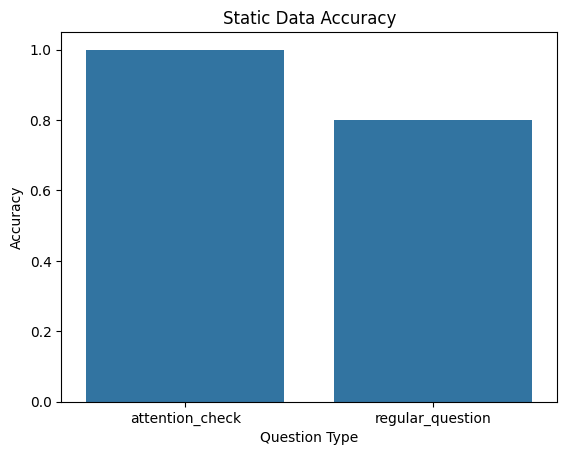

In [26]:
# plot average attention check results and regular question results in the same plot as bars with standard error
attention_check_df = pd.DataFrame.from_dict(subject_attention_check, orient='index', columns=['results'])
regular_question_df = pd.DataFrame.from_dict(subject_regular_questions, orient='index', columns=['results'])

attention_check_df['type'] = 'attention_check'
regular_question_df['type'] = 'regular_question'

combined_df = pd.concat([attention_check_df, regular_question_df])
sns.barplot(x='type', y='results', data=combined_df)
plt.xlabel('Question Type')
plt.ylabel('Accuracy')
plt.title('Static Data Accuracy')
plt.savefig('static_data_accuracy.png', dpi=300)